In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('..')
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tfvpc.model.resnet2D import Resnet2DBuilder
from tfvpc.preprocessing.two_dim import load_batch_dataset
from tfvpc.preprocessing.two_dim import count_tfrecord_examples
from tfvpc.utils.vis import show_confusion_matrix
from tensorflow_addons.losses import SigmoidFocalCrossEntropy


gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2021-08-31 20:05:23.641030: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-31 20:05:25.079042: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-31 20:05:25.103479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 20:05:25.104043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-31 20:05:25.104066: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-31 20:05:25.106977: I tensorflow/stream_executor/platform/default

In [3]:
w_path = '../checkpoints/'
out_path = '../data/tfrecods/'
out_val_fname = 'val-2D-6cls-10'
out_test_fname = 'test-2D-6cls-10'
model_fname = '../checkpoints/resnet05-2D-6cls_checkpoint-10.h5'
out_val_ffname = os.path.join(out_path, out_val_fname + '.tfrecords')
out_test_ffname = os.path.join(out_path, out_test_fname + '.tfrecords')

# patch size: [n_rows, n_cols, n_planes]
n_rows = 32
n_cols = 32
n_classes = 6
vocab = [1,2,3,4,5,6]
n_channel = 1
epoch = 100
batch_size = 128
seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
val_dataset = load_batch_dataset(epoch,
                                 batch_size, 
                                 out_test_ffname,
                                 vocab,
                                 n_classes,
                                 aug =False, 
                                 train=False,
                                normalize = True)
print(f'nm of samples: {count_tfrecord_examples(out_test_ffname)}')
print(val_dataset.element_spec)

2021-08-31 20:05:44.896273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-31 20:05:44.897820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 20:05:44.898412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-31 20:05:44.898514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but th

nm of samples: 21235
(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))


# define model and load weights

In [5]:
resnet = Resnet2DBuilder.build_resnet_05((n_rows, n_cols, n_channel), n_classes)
resnet.load_weights(model_fname)
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
metrics = [
    F1Score(n_classes, name='F1'),
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
#compile model
resnet.compile(optimizer='adam',
               loss= 'categorical_crossentropy',
#                loss=SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO),
               metrics=metrics)
results = resnet.evaluate(val_dataset, batch_size=batch_size)

2021-08-31 20:05:51.282956: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-31 20:05:51.869501: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-08-31 20:05:52.486441: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


     20/Unknown - 3s 6ms/step - loss: 0.8409 - F1: 0.2540 - accuracy: 0.7480 - precision: 0.7530 - recall: 0.7383 - auc: 0.9432 - prc: 0.7770

2021-08-31 20:05:53.019809: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


166/166 [==============================] - 4s 5ms/step - loss: 0.7226 - F1: 0.7153 - accuracy: 0.7478 - precision: 0.7631 - recall: 0.7277 - auc: 0.9520 - prc: 0.7902


In [7]:
validation_array = np.array(list(val_dataset.unbatch().take(-1).as_numpy_iterator()))
val_x = np.stack(validation_array[:,0])
val_y = np.stack(validation_array[:,1])
test_preds = resnet.predict(val_x)
test_lbls_pred = np.argmax(test_preds, axis=1)
test_lbls_gt =  np.argmax((val_y), axis=1)

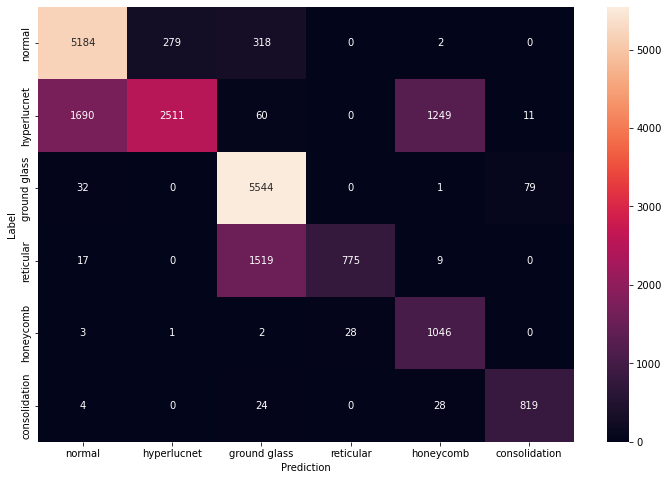

In [8]:
cf_matrix = tf.math.confusion_matrix(test_lbls_gt, test_lbls_pred)
label_names = ['normal','hyperlucnet','ground glass','reticular','honeycomb','consolidation']
show_confusion_matrix(cf_matrix, label_names)
n_per_class = cf_matrix.numpy().sum(axis=1)
tp_plus_fp_per_class = cf_matrix.numpy().sum(axis=0)
tp_per_class = tf.linalg.diag_part(cf_matrix).numpy()
fp_per_class = tp_plus_fp_per_class - tp_per_class
fn_per_class = n_per_class - tp_per_class
tn_per_class = cf_matrix.numpy().sum() - tp_per_class - fp_per_class - fn_per_class
acc_per_class = (tp_per_class+tn_per_class) / (tp_per_class + fn_per_class + tn_per_class + fp_per_class)
precision_per_class = tp_per_class / tp_plus_fp_per_class
recall_per_class = tp_per_class / (tp_per_class + fn_per_class)
f1_per_class = (2*(precision_per_class * recall_per_class))/ (precision_per_class + recall_per_class)
specificity_per_class = tn_per_class / (tn_per_class + fp_per_class) 
ba_acc_per_class = (specificity_per_class + recall_per_class) / 2




In [9]:
# extract tp
def extract_tp_perclass(test_lbls_gt, test_preds, cls_to_visualize):
    # get indices for test patches
    idx = np.array(list(range(len(test_lbls_gt))))
    # Extact FNs

    # mask to extract patches that belong to class-visualize
    mask_cls = test_lbls_gt == cls_to_visualize
    # extract indices of patches that belong to class-visualize
    idx_cls = idx[mask_cls]
    # mask to True positives
    mask_tp = test_lbls_pred[idx_cls] == cls_to_visualize 
    idx_cls_tp = idx_cls[mask_tp]
    test_preds_tp = test_preds[idx_cls_tp, cls_to_visualize]
    test_lbls_pred_tp = test_lbls_pred[idx_cls_tp]
    test_patches_tp = val_x[idx_cls_tp, ...]
    idx_cls_tp_ordered =  idx_cls_tp[test_preds_tp.argsort()][::-1]
    
    return idx_cls_tp_ordered

In [15]:
out_path_save = '../patch_results/test/'
cls_to_visualize = 1
cls_name = 'hyperlucent'

idx_cls_tp_ordered = extract_tp_perclass(test_lbls_gt, test_preds, cls_to_visualize)
print(idx_cls_tp_ordered.shape)
for i in idx_cls_tp_ordered.tolist():
    
    patch_i = val_x[i, ...]
    gt_lbl_i = test_lbls_gt[i]
    lbl_pred_i = test_lbls_pred[i]
    pred_i = test_preds[i, cls_to_visualize]
    img_filename = os.path.join(cls_name + '_' + str(i)+'.jpeg')
    print(img_filename)
    out_path_ = os.path.join(out_path_save, cls_name)
    if not os.path.exists(out_path_):
        os.makedirs(out_path_)
    img_filename = os.path.join(out_path_ ,img_filename)
    plt.imsave(img_filename, patch_i[...,0], cmap='gray')
    
#     break

(2511,)
hyperlucent_1784.jpeg
hyperlucent_1788.jpeg
hyperlucent_1789.jpeg
hyperlucent_2032.jpeg
hyperlucent_1950.jpeg
hyperlucent_2028.jpeg
hyperlucent_1708.jpeg
hyperlucent_1800.jpeg
hyperlucent_1792.jpeg
hyperlucent_1952.jpeg
hyperlucent_1716.jpeg
hyperlucent_2026.jpeg
hyperlucent_1880.jpeg
hyperlucent_1947.jpeg
hyperlucent_1865.jpeg
hyperlucent_1795.jpeg
hyperlucent_1712.jpeg
hyperlucent_1868.jpeg
hyperlucent_1794.jpeg
hyperlucent_1967.jpeg
hyperlucent_1713.jpeg
hyperlucent_1959.jpeg
hyperlucent_1864.jpeg
hyperlucent_1791.jpeg
hyperlucent_1659.jpeg
hyperlucent_1785.jpeg
hyperlucent_2031.jpeg
hyperlucent_1953.jpeg
hyperlucent_2029.jpeg
hyperlucent_1887.jpeg
hyperlucent_6323.jpeg
hyperlucent_1798.jpeg
hyperlucent_1715.jpeg
hyperlucent_1718.jpeg
hyperlucent_2023.jpeg
hyperlucent_1871.jpeg
hyperlucent_2017.jpeg
hyperlucent_1811.jpeg
hyperlucent_2020.jpeg
hyperlucent_1719.jpeg
hyperlucent_1876.jpeg
hyperlucent_1944.jpeg
hyperlucent_1735.jpeg
hyperlucent_2016.jpeg
hyperlucent_2305.jpeg
hy

hyperlucent_4222.jpeg
hyperlucent_5967.jpeg
hyperlucent_3338.jpeg
hyperlucent_2175.jpeg
hyperlucent_6213.jpeg
hyperlucent_3728.jpeg
hyperlucent_1974.jpeg
hyperlucent_6328.jpeg
hyperlucent_6128.jpeg
hyperlucent_4798.jpeg
hyperlucent_6104.jpeg
hyperlucent_3241.jpeg
hyperlucent_4466.jpeg
hyperlucent_4256.jpeg
hyperlucent_3806.jpeg
hyperlucent_4020.jpeg
hyperlucent_6167.jpeg
hyperlucent_6285.jpeg
hyperlucent_2272.jpeg
hyperlucent_4523.jpeg
hyperlucent_6169.jpeg
hyperlucent_1834.jpeg
hyperlucent_6156.jpeg
hyperlucent_3877.jpeg
hyperlucent_2248.jpeg
hyperlucent_6399.jpeg
hyperlucent_5196.jpeg
hyperlucent_3888.jpeg
hyperlucent_2054.jpeg
hyperlucent_1605.jpeg
hyperlucent_1539.jpeg
hyperlucent_6364.jpeg
hyperlucent_3510.jpeg
hyperlucent_6592.jpeg
hyperlucent_1841.jpeg
hyperlucent_3331.jpeg
hyperlucent_6556.jpeg
hyperlucent_5948.jpeg
hyperlucent_2134.jpeg
hyperlucent_6450.jpeg
hyperlucent_2049.jpeg
hyperlucent_3576.jpeg
hyperlucent_4465.jpeg
hyperlucent_2345.jpeg
hyperlucent_6150.jpeg
hyperlucen

hyperlucent_3335.jpeg
hyperlucent_5956.jpeg
hyperlucent_4988.jpeg
hyperlucent_6468.jpeg
hyperlucent_4351.jpeg
hyperlucent_4669.jpeg
hyperlucent_2229.jpeg
hyperlucent_3486.jpeg
hyperlucent_6378.jpeg
hyperlucent_3599.jpeg
hyperlucent_4299.jpeg
hyperlucent_1737.jpeg
hyperlucent_4109.jpeg
hyperlucent_6346.jpeg
hyperlucent_4372.jpeg
hyperlucent_2323.jpeg
hyperlucent_3644.jpeg
hyperlucent_1522.jpeg
hyperlucent_4864.jpeg
hyperlucent_4374.jpeg
hyperlucent_5106.jpeg
hyperlucent_4868.jpeg
hyperlucent_1833.jpeg
hyperlucent_4052.jpeg
hyperlucent_2341.jpeg
hyperlucent_2330.jpeg
hyperlucent_5162.jpeg
hyperlucent_4671.jpeg
hyperlucent_3194.jpeg
hyperlucent_4120.jpeg
hyperlucent_6017.jpeg
hyperlucent_6473.jpeg
hyperlucent_5051.jpeg
hyperlucent_1483.jpeg
hyperlucent_2355.jpeg
hyperlucent_2221.jpeg
hyperlucent_1514.jpeg
hyperlucent_4724.jpeg
hyperlucent_3598.jpeg
hyperlucent_5940.jpeg
hyperlucent_4464.jpeg
hyperlucent_5197.jpeg
hyperlucent_3787.jpeg
hyperlucent_6033.jpeg
hyperlucent_5315.jpeg
hyperlucen

hyperlucent_2187.jpeg
hyperlucent_3495.jpeg
hyperlucent_4391.jpeg
hyperlucent_6265.jpeg
hyperlucent_3903.jpeg
hyperlucent_2857.jpeg
hyperlucent_5780.jpeg
hyperlucent_5936.jpeg
hyperlucent_2214.jpeg
hyperlucent_2189.jpeg
hyperlucent_5248.jpeg
hyperlucent_1488.jpeg
hyperlucent_2313.jpeg
hyperlucent_4734.jpeg
hyperlucent_1455.jpeg
hyperlucent_3287.jpeg
hyperlucent_4602.jpeg
hyperlucent_3491.jpeg
hyperlucent_5273.jpeg
hyperlucent_2286.jpeg
hyperlucent_3378.jpeg
hyperlucent_6340.jpeg
hyperlucent_3409.jpeg
hyperlucent_6550.jpeg
hyperlucent_4663.jpeg
hyperlucent_1997.jpeg
hyperlucent_6575.jpeg
hyperlucent_2955.jpeg
hyperlucent_6177.jpeg
hyperlucent_6457.jpeg
hyperlucent_3192.jpeg
hyperlucent_1857.jpeg
hyperlucent_4536.jpeg
hyperlucent_3081.jpeg
hyperlucent_4038.jpeg
hyperlucent_6180.jpeg
hyperlucent_4415.jpeg
hyperlucent_2151.jpeg
hyperlucent_4931.jpeg
hyperlucent_3709.jpeg
hyperlucent_6069.jpeg
hyperlucent_3087.jpeg
hyperlucent_5980.jpeg
hyperlucent_4664.jpeg
hyperlucent_3785.jpeg
hyperlucen

hyperlucent_3233.jpeg
hyperlucent_3243.jpeg
hyperlucent_3230.jpeg
hyperlucent_1530.jpeg
hyperlucent_4933.jpeg
hyperlucent_1307.jpeg
hyperlucent_4579.jpeg
hyperlucent_4407.jpeg
hyperlucent_3099.jpeg
hyperlucent_2140.jpeg
hyperlucent_3198.jpeg
hyperlucent_1903.jpeg
hyperlucent_3176.jpeg
hyperlucent_2093.jpeg
hyperlucent_4998.jpeg
hyperlucent_4982.jpeg
hyperlucent_5060.jpeg
hyperlucent_3660.jpeg
hyperlucent_4455.jpeg
hyperlucent_6269.jpeg
hyperlucent_1768.jpeg
hyperlucent_2833.jpeg
hyperlucent_5221.jpeg
hyperlucent_3548.jpeg
hyperlucent_3268.jpeg
hyperlucent_1823.jpeg
hyperlucent_3416.jpeg
hyperlucent_1654.jpeg
hyperlucent_4862.jpeg
hyperlucent_5992.jpeg
hyperlucent_2952.jpeg
hyperlucent_4647.jpeg
hyperlucent_5309.jpeg
hyperlucent_1783.jpeg
hyperlucent_3195.jpeg
hyperlucent_5199.jpeg
hyperlucent_1827.jpeg
hyperlucent_2129.jpeg
hyperlucent_2064.jpeg
hyperlucent_1366.jpeg
hyperlucent_4226.jpeg
hyperlucent_3267.jpeg
hyperlucent_2831.jpeg
hyperlucent_2004.jpeg
hyperlucent_1084.jpeg
hyperlucen

In [ ]:
idx_cls_tp_ordered.shape

In [ ]:
out_path_

In [ ]:
from PIL import Image
patch_i = patch_i.astype(np.uint8)
im = Image.fromarray(patch_i[...,0])
im.save("filename.jpeg")

In [ ]:
plt.imsave('test.png',patch_i[...,0], cmap='gray')

In [ ]:
cls_to_visualize = 3
# get indices for test patches
idx = np.array(list(range(len(test_lbls_gt))))
# Extact FNs

# mask to extract patches that belong to class-visualize
mask_cls = test_lbls_gt == cls_to_visualize
# extract indices of patches that belong to class-visualize
idx_cls = idx[mask_cls]
# mask to True positives
mask_tp = test_lbls_pred[idx_cls] == cls_to_visualize 
idx_cls_tp = idx_cls[mask_tp]
test_preds_tp = test_preds[idx_cls_tp, cls_to_visualize]
test_lbls_pred_tp = test_lbls_pred[idx_cls_tp]
test_patches_tp = val_x[idx_cls_tp, ...]
idx_cls_tp_ordered =  idx_cls_tp[test_preds_tp.argsort()][::-1]


# mask to extract patches that belong to class-visualize
mask_cls = test_lbls_gt == cls_to_visualize
# extract indices of patches that belong to class-visualize
idx_cls = idx[mask_cls]
# mask to False Negatives
mask_fn = test_lbls_pred[idx_cls] != cls_to_visualize 
idx_cls_fn = idx_cls[mask_fn]
test_preds_fn = test_preds[idx_cls_fn, cls_to_visualize]
test_lbls_pred_fn = test_lbls_pred[idx_cls_fn]
test_patches_fn = val_x[idx_cls_fn, ...]

# Extract TPs

# mask to extract patches predicted as class-visualize
mask_cls_pred = test_lbls_pred == cls_to_visualize
idx_cls_pred = idx[mask_cls_pred]
mask_fp = test_lbls_pred[idx_cls_pred] != test_lbls_gt[idx_cls_pred] 

idx_cls_fp = idx_cls_pred[mask_fp]
test_preds_fp = test_preds[idx_cls_fp, cls_to_visualize]
test_lbls_pred_fp = test_lbls_pred[idx_cls_fp]
test_lbls_gt_fp = test_lbls_gt[idx_cls_fp]
test_patches_fp = val_x[idx_cls_fp, ...]

idx_cls_fp_ordered =  idx_cls_fp[test_preds_fp.argsort()][::-1]

for i in idx_cls_fp_ordered.tolist():

    patch_i = val_x[i, ...]
    gt_lbl_i = test_lbls_gt[i]
    lbl_pred_i = test_lbls_pred[i]
    pred_i = test_preds[i, cls_to_visualize]
    
    print(gt_lbl_i, lbl_pred_i, pred_i)
    break

In [ ]:
#TPs
from IPython.display import clear_output
import time
for i in idx_cls_tp.tolist():
    
    patch_i = val_x[i, ...]
    gt_lbl_i = test_lbls_gt[i]
    lbl_pred_i = test_lbls_pred[i]
    pred_i = test_preds[i, cls_to_visualize]
    
    print(i, gt_lbl_i, lbl_pred_i, pred_i)
    fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 8))
    axs.set_title('raw')
    axs.imshow(patch_i, cmap='gray')
    plt.show()
    clear_output(wait=True)
    time.sleep(1.99)
    break

In [ ]:
index = idx_cls_tp[test_preds_tp==test_preds_tp.min()]
plt.imshow(validation_array[index[0],0], cmap='gray')
index[0]

In [ ]:
#FPs
from IPython.display import clear_output
import time
for i in idx_cls_fp_ordered.tolist():
    
    patch_i = val_x[i, ...]
    gt_lbl_i = test_lbls_gt[i]
    lbl_pred_i = test_lbls_pred[i]
    pred_i = test_preds[i, cls_to_visualize]
#     if gt_lbl_i==2:
    
    print(i, gt_lbl_i, lbl_pred_i, pred_i)
    fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 8))
    axs.set_title('raw')
    axs.imshow(patch_i, cmap='gray')
    plt.show()
    clear_output(wait=True)
    time.sleep(0.99)
    break
    